In [ ]:
from __future__ import annotations

from custom_slope_providers import (
    LsqPlane,
    MaxSlope,
    MaxTSlope,
    PolynomBRB,
    PolynomE,
    PolynomH,
    PolynomHB,
    PolynomZT,
)
import geopandas as gpd

from slope_area.builder import BuilderConfig, ResolutionPlotBuilder
from slope_area.enums import SlopeAreaMethod
from slope_area.features import Outlets
from slope_area.geomorphometry import HydrologicAnalysisConfig
from slope_area.logger import create_logger
from slope_area.paths import PROJ_ROOT
from slope_area.plot import SlopeAreaPlotConfig

logger = create_logger(__name__)

00:49:40 DEBUG slopeArea.slope_area.config          is_notebook(): Code is running in notebook


# Paths

In [ ]:
dem = PROJ_ROOT / 'data' / 'raw' / 'copdem_30m.tif'
outlets = PROJ_ROOT / 'data' / 'raw' / 'copdem_30m_outlets.shp'

out_dir = PROJ_ROOT / 'data' / 'processed' / '03_custom_slope_providers'
out_dir_resolution_builder = out_dir / 'resolution_builder'
out_fig_resolution_builder = out_dir_resolution_builder / 'slope_area.png'

assert dem.exists()
assert outlets.exists()

# Configs

In [ ]:
max_workers = 3
resolutions = [(res, res) for res in range(30, 60, 5)]
hydrologic_analysis_config = HydrologicAnalysisConfig(
    streams_flow_accumulation_threshold=1000, outlet_snap_distance=100
)

plot_config = SlopeAreaPlotConfig(
    hue='slope_type',
    col='trial',
    row=None,
    log_interval=0.25,
    min_gradient=0.01,
    col_wrap=-1,
    height=5,
    aspect=1,
    title=None,
    xlabel='Drainage area (m$^2$)',
    ylabel='Slope (m/m)',
    label_font_size=16,
    title_font_size=10,
    legend_font_size=10,
    tick_font_size=14,
    add_vlines=False,
    kind='line',
    show=False,
)

# Read outlets

In [ ]:
logger.info('Reading outlets at %s' % outlets)
gdf = gpd.read_file(outlets).sort_values(by='name')
outlets = Outlets.from_gdf(gdf, name_field='name')

00:49:44 INFO slopeArea.__main__             <module>(): Reading outlets at C:\Users\alex\Desktop\slope-area\data\raw\copdem_30m_outlets.shp


# Slope providers (SAGA Version: 9.8.0)

In [ ]:
slope_providers = {
    'maximum slope (Travis et al. 1975)': MaxSlope(),
    'maximum triangle slope (Tarboton 1997)': MaxTSlope(),
    'least squares fitted plane (Horn 1981, Costa-Cabral & Burgess 1996)': LsqPlane(),
    '6 parameter 2nd order polynom (Evans 1979)': PolynomE(),
    '6 parameter 2nd order polynom (Heerdegen & Beran 1982)': PolynomHB(),
    '6 parameter 2nd order polynom (Bauer, Rohdenburg, Bork 1985)': PolynomBRB(),
    '9 parameter 2nd order polynom (Zevenbergen & Thorne 1987)': PolynomZT(),
    '10 parameter 3rd order polynom (Haralick 1983)': PolynomH(),
}

# Run trials with Builder objects

## ResolutionPlotBuilder - multiple resolutions for one outlet

Output()

00:52:07 INFO slopeArea.slope_area.builder.TrialsExecutor               gather(): Gathering results of TrialsExecutor
00:52:07 INFO slopeArea.slope_area.plot      slope_area_grid(): Creating slope area plot with config SlopeAreaPlotConfig(hue='slope_type', col='trial', row=None, log_interval=0.25, min_gradient=0.01, col_wrap=-1, height=5, aspect=1, title=None, xlabel='Drainage area (m$^2$)', ylabel='Slope (m/m)', label_font_size=16, title_font_size=10, tick_font_size=14, add_vlines=False, kind='line', grid=True, legend_font_size=10, legend_title='', legend=True, show=False)
00:52:07 INFO slopeArea.slope_area.plot         get_col_wrap(): Infered 3 cols for the plot
00:52:20 INFO slopeArea.slope_area.plot      slope_area_grid(): Saved slope area plot at C:\Users\alex\Desktop\slope-area\data\processed\03_custom_slope_providers\resolution_builder\slope_area.png


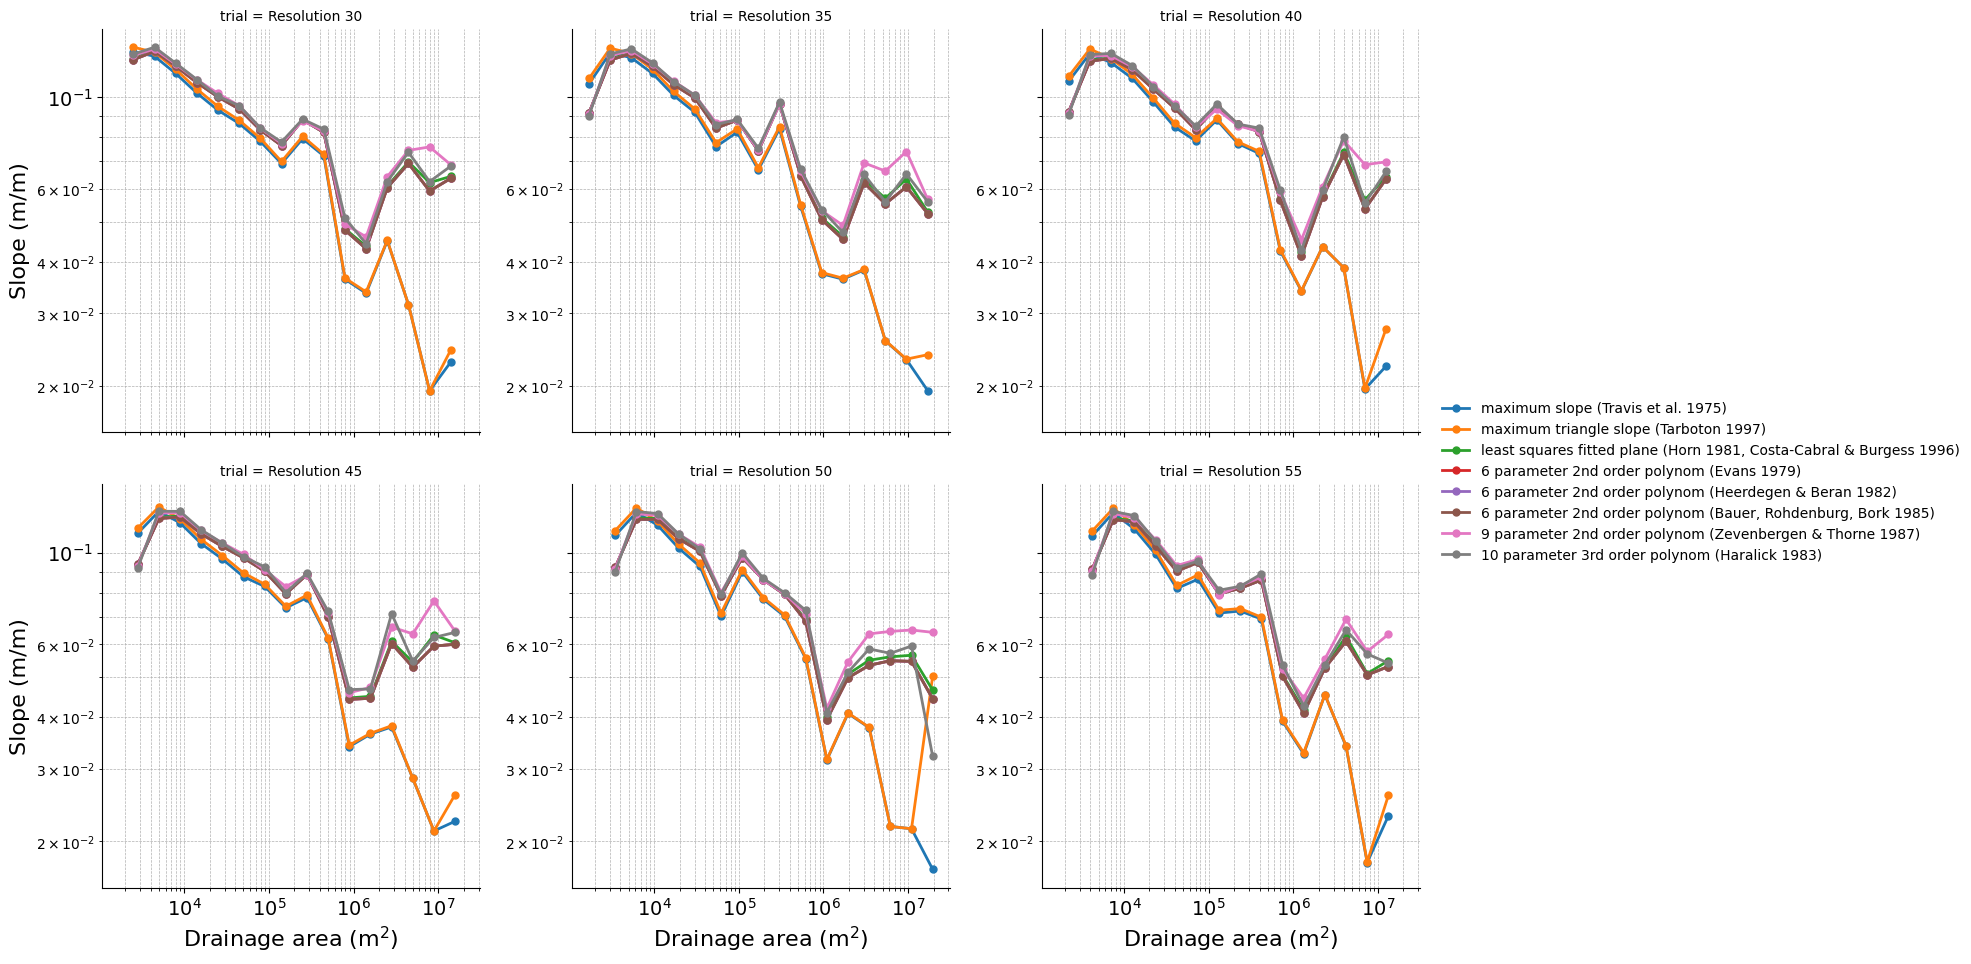

In [ ]:
outlet = outlets[0]

builder_config = BuilderConfig(
    hydrologic_analysis_config=hydrologic_analysis_config,
    out_dir=out_dir_resolution_builder,
    out_fig=out_fig_resolution_builder,
    method=SlopeAreaMethod.STREAMS,
    plot_config=plot_config,
    max_workers=max_workers,
    slope_providers=slope_providers,
)
outlet_builder = ResolutionPlotBuilder(
    builder_config, dem=dem, outlet=outlet, resolutions=resolutions
)
results = outlet_builder.build()